In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from synthetic_datasets import BatchedInContextRecallDataset
from meta_optimizers import MetaSGD
from memory_module import inner_optimization_forward, TTT
from model_components import HyperparamModel, LearnableHyperparam
from evaluate import compute_recall_accuracies, correct_retrieval_counts_by_timestep, average_accuracy_by_offset

In [8]:
key_dim=10
val_dim=10
context_size=5 # inner loss computation window
seq_len=100
batch_size=1
output_corr=0
inner_optimizer=MetaSGD()
#inner_optimizer_kwargs={ "beta": torch.tensor(0.9)}
#outer_optimizer_kwargs={"lr": 0.01}

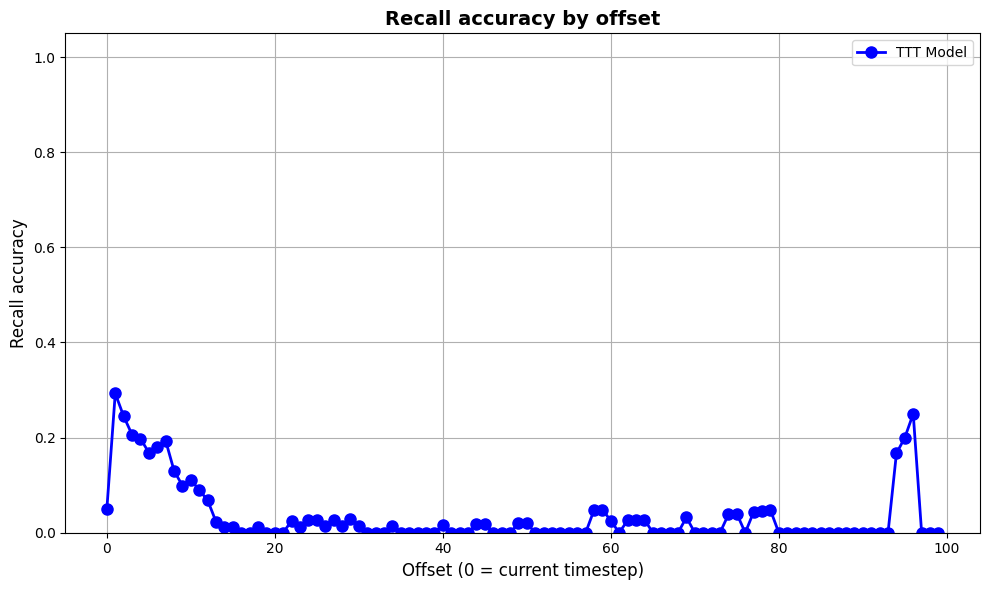

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dataset = BatchedInContextRecallDataset(
    seq_len=seq_len,
    key_dim=key_dim,
    val_dim=val_dim,
    context_size=context_size,
    batch_size=batch_size,
)    

_, predictions = inner_optimization_forward(
    memory_module=TTT(key_dim,val_dim,1, 0.0).to(device),
    dataset=dataset.to(device),
    inner_opt=inner_optimizer,
    lr_head=0.1,
    loss_weight_head=torch.ones(context_size).to(device),
    eval_mode=True
)

accuracies = compute_recall_accuracies(predictions,dataset.targets)
accuracy_by_offset, count = average_accuracy_by_offset(accuracies)


# Convert dictionary to arrays for proper plotting
offsets = np.arange(len(accuracy_by_offset))
accuracies_array = accuracy_by_offset.to("cpu")

# Plot average accuracy by offset
plt.figure(figsize=(10, 6))
plt.plot(offsets, accuracies_array, 'bo-', linewidth=2, markersize=8, label='TTT Model')
plt.xlabel("Offset (0 = current timestep)", fontsize=12)
plt.ylabel("Recall accuracy", fontsize=12)
plt.title("Recall accuracy by offset", fontsize=14, fontweight='bold')
plt.ylim(0.0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [6]:
import pickle

# Load a pickle file
with open('/home/omni/Documents/programming_projects/old_ICR/old_commit/src/saved_results/all_datasets.pkl', 'rb') as f:
    data = pickle.load(f)

all_inputs = data["inputs"]
all_targets = data["targets"]

with open("/home/omni/Documents/programming_projects/old_ICR/old_commit/src/saved_results/accuracy_histories_lr_0.1.pkl", "rb") as f:
    old_accuracy_histories = pickle.load(f)

# Flip each tensor in old_accuracy_histories so that position (b,j) corresponds to input j
# instead of input t-j
flipped_accuracy_histories = []
for tensor in old_accuracy_histories:
    # Convert numpy array to PyTorch tensor if needed
    if not torch.is_tensor(tensor):
        tensor = torch.from_numpy(tensor)
    # Flip along the last dimension (j dimension) to reverse the time offset
    flipped_tensor = torch.flip(tensor, dims=[-1])
    flipped_accuracy_histories.append(flipped_tensor)

# Replace the original with flipped version
old_accuracy_histories = flipped_accuracy_histories

Mean offset accuracy gap (current - old): -0.0374


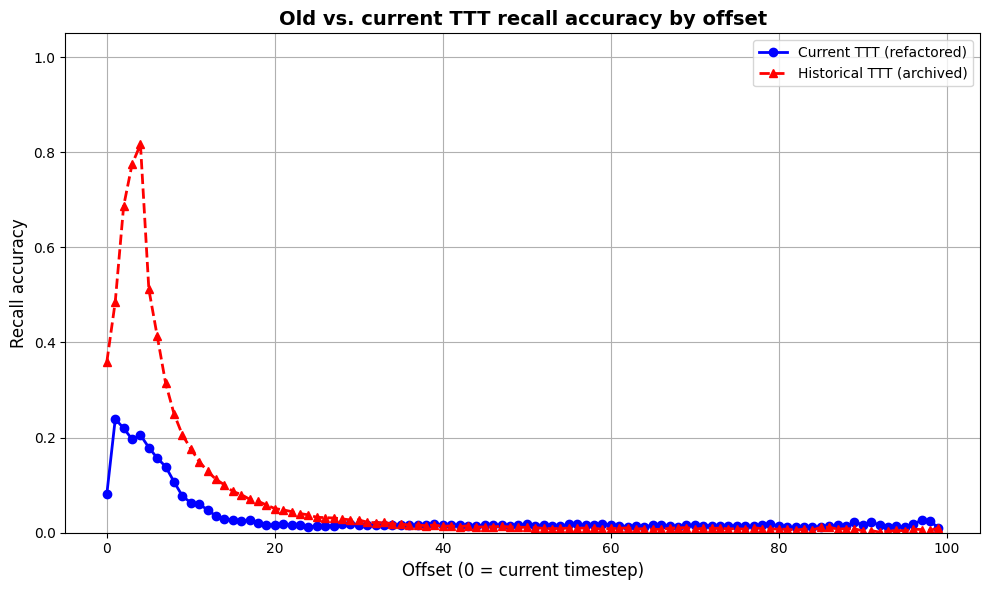

In [7]:
# Evaluate the refactored TTT on the stored historical dataset and compare with archived accuracies.

def _prepare_tensor(data):
    # Clone tensor-like inputs and cast to the default dtype for evaluation.
    tensor = data.clone() if torch.is_tensor(data) else torch.as_tensor(data, dtype=torch.get_default_dtype())
    return tensor.to(torch.get_default_dtype())

historical_inputs = _prepare_tensor(all_inputs)
historical_targets = _prepare_tensor(all_targets)

historical_dataset = BatchedInContextRecallDataset(
    seq_len=historical_inputs.shape[1],
    key_dim=historical_inputs.shape[2],
    val_dim=historical_targets.shape[2],
    context_size=context_size,
    batch_size=historical_inputs.shape[0],
)

# Overwrite the randomly initialized data with the archived batch so indexing logic stays consistent.
historical_dataset.inputs = historical_inputs
historical_dataset.targets = historical_targets
historical_dataset = historical_dataset.to(device)

historical_ttt = TTT(
    input_dim=historical_inputs.shape[2],
    output_dim=historical_targets.shape[2],
    num_layers=1,
    init_var=0.0,
).to(device)

_, historical_predictions = inner_optimization_forward(
    memory_module=historical_ttt,
    dataset=historical_dataset,
    inner_opt=inner_optimizer,
    lr_head=0.1,
    loss_weight_head=torch.ones(context_size, device=device),
    eval_mode=True,
)

current_accuracy_histories = compute_recall_accuracies(
    historical_predictions,
    historical_dataset.targets,
)

old_offset_accuracy, _ = average_accuracy_by_offset(old_accuracy_histories)
current_offset_accuracy, _ = average_accuracy_by_offset(current_accuracy_histories)

max_offsets = max(len(old_offset_accuracy), len(current_offset_accuracy))

def _pad_offsets(tensor, length):
    if tensor.shape[0] == length:
        return tensor
    padded = torch.full((length,), float('nan'), device=tensor.device, dtype=tensor.dtype)
    padded[: tensor.shape[0]] = tensor
    return padded

aligned_old = _pad_offsets(old_offset_accuracy.to(current_offset_accuracy.device), max_offsets)
aligned_current = _pad_offsets(current_offset_accuracy, max_offsets)

valid_mask = (~torch.isnan(aligned_old)) & (~torch.isnan(aligned_current))
offset_deltas = aligned_current[valid_mask] - aligned_old[valid_mask]
mean_gap = offset_deltas.mean().item() if offset_deltas.numel() else float('nan')
print(f"Mean offset accuracy gap (current - old): {mean_gap:+.4f}")

offset_axis = np.arange(max_offsets)
old_curve = np.ma.masked_invalid(aligned_old.to('cpu').numpy())
current_curve = np.ma.masked_invalid(aligned_current.to('cpu').numpy())

plt.figure(figsize=(10, 6))
plt.plot(offset_axis, current_curve, 'bo-', linewidth=2, markersize=6, label='Current TTT (refactored)')
plt.plot(offset_axis, old_curve, 'r^--', linewidth=2, markersize=6, label='Historical TTT (archived)')
plt.xlabel("Offset (0 = current timestep)", fontsize=12)
plt.ylabel("Recall accuracy", fontsize=12)
plt.title("Old vs. current TTT recall accuracy by offset", fontsize=14, fontweight='bold')
plt.ylim(0.0, 1.05)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
